#Missing Data Imputation
Datasets may have missing values, and this can cause problems for many machine learning
algorithms. As such, it is good practice to identify and replace missing values for each column in
your input data prior to modeling your prediction task. This is called missing data imputation,
or imputing for short.

In this tutorial, you will learn:

* How to load a CSV file with missing values and mark the missing values with NaN values
and report the number and percentage of missing values for each column.
* How to impute missing values with statistics as a data preparation method when evaluating models and when fitting a final model to make predictions on new data.
* How to impute missing values with nearest neighbor models as a data preparation method when evaluating models and when fitting a final model to make predictions on new data.
* How to impute missing values with iterative imputation models as a data preparation method when evaluating models and when fitting a final model to make predictions on new data.

Credit: Jason Brownlee. 2020. [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/).

###Horse Colic Dataset
The horse colic dataset describes medical characteristics of horses with colic and whether they
lived or died. There are 300 rows and 26 input variables with one output variable. It is a binary
classification prediction task that involves predicting 1 if the horse lived and 2 if the horse died.
There are many fields we could select to predict in this dataset. In this case, we will predict
whether the problem was surgical or not (column index 23), making it a binary classification
problem. The dataset has numerous missing values for many of the columns where each missing
value is marked with a question mark character ("\?"). 

Number of Instances: 368 (300 for training, 68 for testing)

Number of attributes: 28

Attribute Information:
```
1: Surgery, 2: Age, 3: Hospital Number, 4: Rectal Temperature, 5: Pulse, 6: Respiratory Rate, 7: Temperature of Exteremities,
8: Peripheral Pulse, 9: Mucous Membrances, 10: Capillary Refill Time, 11: Pain, 12: Peristalsis, 13: Abdominal Distension, 
14: Nasogastric Tube, 15: Nasogastric Reflux, 16: Nasogastric Reflux PH, 17: Rectal Examinataion, 18: Abdomen, 
19: Packed Cell Volume, 20: Total Protein, 21: Abdominocentesis Appearance, 22: Abdomcentesis Total Protein, 23: Outcome, 
24: Surgical Lesion, 25, 26, 27: Type of Lesion, 28. cp_data

```


You can learn more about the dataset
here:
* Horse Colic Dataset ([horse-colic.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv))
* Horse Colic Dataset Description ([horse-colic.names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.names))

The description of Horse Colic Dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Horse+Colic).

###Download Horse Colic data files

In [2]:
!pip install wget
!python -m wget -o horse-colic.csv "https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv" 
!python -m wget -o horse-colic.names "https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.names"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d65f14a684603b3b84a9070ac687f3bdae981f19ff4abdb80853e3199f3c41c5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget

Saved under horse-colic.csv

Saved under horse-colic.names


##Statistical Imputation
A dataset may have missing values. These are rows of data where one or more values or columns
in that row are not present. The values may be missing completely or they may be marked with
a special character or value, such as a question mark ("\?").

Values could be missing for many reasons, often specific to the problem domain, and might
include reasons such as corrupt measurements or data unavailability.

Most machine learning algorithms require numeric input values, and a value to be present
for each row and column in a dataset. As such, missing values can cause problems for machine
learning algorithms. Because of this, it is common to identify missing values in a dataset and
replace them with a numeric value. This is called data imputing, or missing data imputation.

A simple and popular approach to data imputation involves using statistical methods to
estimate a value for a column from those values that are present, then replace all missing values
in the column with the calculated statistic.

Loading and summarizing a dataset with missing values.

In [3]:
# summarize the horse colic dataset
from pandas import read_csv
# load dataset
df = read_csv('horse-colic.csv', header=None, na_values='?')
# summarize the first few rows
print(df.head())
# summarize the number of rows with missing values for each column
for i in range(df.shape[1]):
# count number of rows with missing values
  n_miss = df[[i]].isnull().sum()
  perc = n_miss / df.shape[0] * 100
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

    0   1        2     3      4     5    6    7    8    9   ...    18    19  \
0  2.0   1   530101  38.5   66.0  28.0  3.0  3.0  NaN  2.0  ...  45.0   8.4   
1  1.0   1   534817  39.2   88.0  20.0  NaN  NaN  4.0  1.0  ...  50.0  85.0   
2  2.0   1   530334  38.3   40.0  24.0  1.0  1.0  3.0  1.0  ...  33.0   6.7   
3  1.0   9  5290409  39.1  164.0  84.0  4.0  1.0  6.0  2.0  ...  48.0   7.2   
4  2.0   1   530255  37.3  104.0  35.0  NaN  NaN  6.0  2.0  ...  74.0   7.4   

    20   21   22  23     24  25  26  27  
0  NaN  NaN  2.0   2  11300   0   0   2  
1  2.0  2.0  3.0   2   2208   0   0   2  
2  NaN  NaN  1.0   2      0   0   0   1  
3  3.0  5.3  2.0   1   2208   0   0   1  
4  NaN  NaN  2.0   2   4300   0   0   2  

[5 rows x 28 columns]
> 0, Missing: 1 (0.3%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 60 (20.0%)
> 4, Missing: 24 (8.0%)
> 5, Missing: 58 (19.3%)
> 6, Missing: 56 (18.7%)
> 7, Missing: 69 (23.0%)
> 8, Missing: 47 (15.7%)
> 9, Missing: 32 (10.7%)
> 10, M

###Statistical Imputation With SimpleImputer

In [ ]:
# statistical imputation transform for the horse colic dataset
from numpy import isnan
from pandas import read_csv
from sklearn.impute import SimpleImputer
# load dataset
df = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# summarize total missing
print('Missing old: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = SimpleImputer(strategy='mean')
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# summarize total missing
print('Missing new: %d' % sum(isnan(Xtrans).flatten()))

Missing old: 1605
Missing new: 0


###SimpleImputer and Model Evaluation

It is a good practice to evaluate machine learning models on a dataset using k-fold cross-
validation. To correctly apply statistical missing data imputation and avoid data leakage, it is
required that the statistics calculated for each column are calculated on the training dataset
only, then applied to the train and test sets for each fold in the dataset.

In [ ]:
# evaluate mean imputation and random forest for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# load dataset
df = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
# KFold 
#   is a cross-validator that divides the dataset into k folds.
# Stratified
#   is to ensure that each fold of dataset has the same proportion of observations with a given label.
# Repeated 
#   provides a way to improve the estimated performance of a machine learning model. 
# This involves simply repeating the cross-validation procedure multiple times and reporting the mean 
# result across all folds from all runs. This mean result is expected to be a more accurate estimate 
# of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
# returns an array of scores of the estimator for each run of the cross validation.
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.864 (0.054)


###Comparing Different Imputed Statistics

We can design an experiment to test
each statistical strategy and discover what works best for this dataset, comparing the mean,
median, mode (most frequent), and constant (0) strategies. The mean accuracy of each approach
can then be compared.

>mean 0.860 (0.059)
>median 0.872 (0.056)
>most_frequent 0.872 (0.060)
>constant 0.874 (0.044)


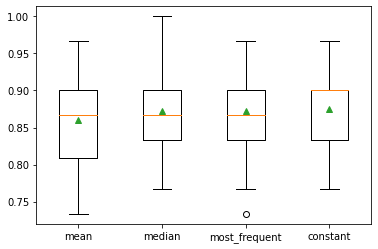

In [ ]:
# compare statistical imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
df = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
# create the modeling pipeline
  pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m',RandomForestClassifier())])
  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # store results
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

At the end of the run, a box and whisker plot is created for each set of results, allowing the
distribution of results to be compared. We can see that the distribution of accuracy scores for
the constant strategy may be better than the other strategies.

###SimpleImputer Transform When Making a Prediction

We may wish to create a final modeling pipeline with the constant imputation strategy and
random forest algorithm, then make a prediction for new data. This can be achieved by defining
the pipeline and fitting it on all available data, then calling the predict() function passing
new data in as an argument. Importantly, the row of new data must mark any missing values
using the NaN value.

In [ ]:
# constant imputation strategy and prediction for the horse colic dataset
from numpy import nan
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# create the modeling pipeline
pipeline = Pipeline(steps=[('i', SimpleImputer(strategy='constant')), ('m',
RandomForestClassifier())])
# fit the model
pipeline.fit(X, y)
# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00,
8.40, nan, nan, 2, 11300, 00000, 00000, 2]
# make a prediction
yhat = pipeline.predict([row])
# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


##KNN Imputation

A popular approach to missing data imputation is to use a model to
predict the missing values. This requires a model to be created for each input variable that has
missing values. Although any one among a range of different models can be used to predict the
missing values, the k-nearest neighbor (KNN) algorithm has proven to be generally effective,
often referred to as nearest neighbor imputation.

###k-Nearest Neighbor Imputation

An effective approach to data imputing is to use a model to predict the missing values. A
model is created for each feature that has missing values, taking as input values of perhaps all
other input features.

If input variables are numeric, then regression models can be used for prediction, and this
case is quite common. A range of different models can be used, although a simple k-nearest
neighbor (KNN) model has proven to be effective in experiments. The use of a KNN model to
predict or fill missing values is referred to as Nearest Neighbor Imputation or KNN imputation.

Configuration of KNN imputation often involves selecting the distance measure (e.g. Eu-clidean) and the number of contributing neighbors for each prediction, the k hyperparameter of
the KNN algorithm.

In [ ]:
# summarize the horse colic dataset
from pandas import read_csv
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# summarize the first few rows
print(dataframe.head())
# summarize the number of rows with missing values for each column
for i in range(dataframe.shape[1]):
# count number of rows with missing values
  n_miss = dataframe[[i]].isnull().sum()
  perc = n_miss / dataframe.shape[0] * 100
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

    0   1        2     3      4     5    6    7    8    9   ...    18    19  \
0  2.0   1   530101  38.5   66.0  28.0  3.0  3.0  NaN  2.0  ...  45.0   8.4   
1  1.0   1   534817  39.2   88.0  20.0  NaN  NaN  4.0  1.0  ...  50.0  85.0   
2  2.0   1   530334  38.3   40.0  24.0  1.0  1.0  3.0  1.0  ...  33.0   6.7   
3  1.0   9  5290409  39.1  164.0  84.0  4.0  1.0  6.0  2.0  ...  48.0   7.2   
4  2.0   1   530255  37.3  104.0  35.0  NaN  NaN  6.0  2.0  ...  74.0   7.4   

    20   21   22  23     24  25  26  27  
0  NaN  NaN  2.0   2  11300   0   0   2  
1  2.0  2.0  3.0   2   2208   0   0   2  
2  NaN  NaN  1.0   2      0   0   0   1  
3  3.0  5.3  2.0   1   2208   0   0   1  
4  NaN  NaN  2.0   2   4300   0   0   2  

[5 rows x 28 columns]
> 0, Missing: 1 (0.3%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 60 (20.0%)
> 4, Missing: 24 (8.0%)
> 5, Missing: 58 (19.3%)
> 6, Missing: 56 (18.7%)
> 7, Missing: 69 (23.0%)
> 8, Missing: 47 (15.7%)
> 9, Missing: 32 (10.7%)
> 10, M

we can see the list of all columns in the dataset and the number and percentage of
missing values. We can see that some columns (e.g. column indexes 1 and 2) have no missing
values and other columns (e.g. column indexes 15 and 21) have many or even a majority of
missing values.

###Nearest Neighbor Imputation with KNNImputer
The scikit-learn machine learning library provides the **KNNImputer** class that supports nearest
neighbor imputation. In this section, we will explore how to effectively use the **KNNImputer**
class.

The **KNNImputer** is a data transform that is first configured based on the method used to
estimate the missing values. The default distance measure is a Euclidean distance measure that
is NaN aware, e.g. will not include NaN values when calculating the distance between members
of the training dataset. This is set via the metric argument. The number of neighbors is set to
 five by default and can be configured by the n neighbors argument.

In [ ]:
# knn imputation transform for the horse colic dataset
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# summarize total missing
print('Missing old: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# summarize total missing
print('Missing new: %d' % sum(isnan(Xtrans).flatten()))

Missing old: 1605
Missing new: 0


###KNNImputer and Model Evaluation
It is a good practice to evaluate machine learning models on a dataset using k-fold cross-
validation. To correctly apply nearest neighbor missing data imputation and avoid data leakage,
it is required that the models calculated for each column are calculated on the training dataset
only, then applied to the train and test sets for each fold in the dataset. This can be achieved
by creating a modeling pipeline where the first step is the nearest neighbor imputation, then
the second step is the model. We will implement this using the Pipeline class. For example,
the Pipeline below uses a KNNImputer with the default strategy, followed by a random forest
model.

In [ ]:
# evaluate knn imputation and random forest for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = KNNImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.861 (0.054)


###KNNImputer and Different Number of Neighbors
The key hyperparameter for the KNN algorithm is **k** that controls the number of nearest
neighbors that are used to contribute to a prediction. It is good practice to test a suite of
different values for **k**.

>1 0.859 (0.051)
>3 0.863 (0.057)
>5 0.858 (0.055)
>7 0.861 (0.056)
>9 0.862 (0.058)
>15 0.864 (0.053)
>18 0.857 (0.056)
>21 0.858 (0.054)


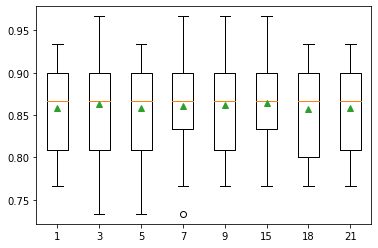

In [ ]:
# compare knn imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
for s in strategies:
  # create the modeling pipeline
  pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m',
  RandomForestClassifier())])
  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # store results
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

###KNNImputer Transform When Making a Prediction
We may wish to create a final modeling pipeline with the nearest neighbor imputation and
random forest algorithm, then make a prediction for new data. This can be achieved by defining
the pipeline and fitting it on all available data, then calling the predict() function, passing
new data in as an argument. Importantly, the row of new data must mark any missing values
using the NaN value.

In [ ]:
# knn imputation strategy and prediction for the horse colic dataset
from numpy import nan
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# create the modeling pipeline
pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=15)), ('m',
RandomForestClassifier())])
# fit the model
pipeline.fit(X, y)
# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00,
8.40, nan, nan, 2, 11300, 00000, 00000, 2]
# make a prediction
yhat = pipeline.predict([row])
# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


##Iterative Imputation

One approach to imputing
missing values is to use an iterative imputation model. Iterative imputation refers to a process
where each feature is modeled as a function of the other features, e.g. a regression problem
where missing values are predicted. Each feature is imputed sequentially, one after the other,
allowing prior imputed values to be used as part of a model in predicting subsequent features.

It is iterative because this process is repeated multiple times, allowing ever improved estimates
of missing values to be calculated as missing values across all features are estimated. This
approach may be generally referred to as fully conditional specification (FCS) or multivariate
imputation by chained equations (MICE).

Different regression algorithms can be used to estimate the missing values for each feature,
although linear methods are often used for simplicity. The number of iterations of the procedure
is often kept small, such as 10. Finally, the order that features are processed sequentially can be
considered, such as from the feature with the least missing values to the feature with the most
missing values.


###Iterative Imputation With IterativeImputer
The scikit-learn machine learning library provides the IterativeImputer class that supports
iterative imputation. In this section, we will explore how to e ectively use the IterativeImputer
class.


IterativeImputer Data Transform
It is a data transform that is  first configured based on the method used to estimate the missing
values. By default, a BayesianRidge model is employed that uses a function of all other input
features. Features are filled in ascending order, from those with the fewest missing values to
those with the most.

In [ ]:
# iterative imputation transform for the horse colic dataset
from numpy import isnan
from pandas import read_csv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# summarize total missing
print('Missing old: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = IterativeImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# summarize total missing
print('Missing new: %d' % sum(isnan(Xtrans).flatten()))

Missing old: 1605
Missing new: 0


IterativeImputer and Model Evaluation
It is a good practice to evaluate machine learning models on a dataset using k-fold cross-
validation. To correctly apply iterative missing data imputation and avoid data leakage, it is
required that the models for each column are calculated on the training dataset only, then
applied to the train and test sets for each fold in the dataset. This can be achieved by creating
a modeling pipeline where the  rst step is the iterative imputation, then the second step is the
model. This can be achieved using the Pipeline class.

In [ ]:
# evaluate iterative imputation and random forest for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = IterativeImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.871 (0.056)


###IterativeImputer and Different Imputation Order
By default, imputation is performed in ascending order from the feature with the least missing
values to the feature with the most. This makes sense as we want to have more complete data
when it comes time to estimating missing values for columns where the majority of values
are missing. Nevertheless, we can experiment with different imputation order strategies, such
as descending, right-to-left (Arabic), left-to-right (Roman), and random.

>ascending 0.869 (0.052)
>descending 0.869 (0.051)
>roman 0.876 (0.053)
>arabic 0.868 (0.051)
>random 0.874 (0.051)


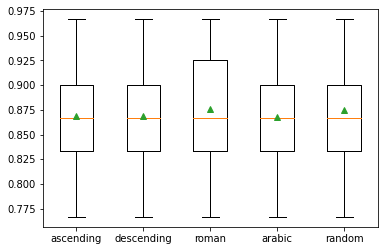

In [ ]:
# compare iterative imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
for s in strategies:
  # create the modeling pipeline
  pipeline = Pipeline(steps=[('i', IterativeImputer(imputation_order=s)), ('m',
  RandomForestClassifier())])
  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # store results
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

###IterativeImputer and Different Number of Iterations
By default, the IterativeImputer will repeat the number of iterations 10 times. It is possible
that a large number of iterations may begin to bias or skew the estimate and that few iterations
may be preferred. The number of iterations of the procedure can be specified via the max iter
argument. It may be interesting to evaluate different numbers of iterations.

>1 0.871 (0.051)
>2 0.876 (0.057)
>3 0.868 (0.048)
>4 0.871 (0.048)
>5 0.872 (0.049)
>6 0.871 (0.057)
>7 0.868 (0.053)
>8 0.877 (0.051)
>9 0.867 (0.052)
>10 0.867 (0.053)
>11 0.873 (0.053)
>12 0.870 (0.050)
>13 0.870 (0.051)
>14 0.868 (0.055)
>15 0.872 (0.056)
>16 0.869 (0.046)
>17 0.871 (0.055)
>18 0.873 (0.057)
>19 0.867 (0.050)
>20 0.868 (0.051)


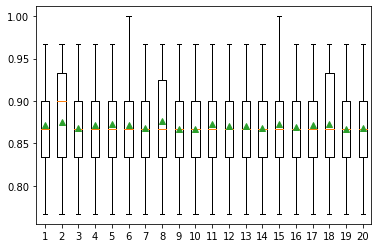

In [ ]:
# compare iterative imputation number of iterations for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in range(1, 21)]
for s in strategies:
  # create the modeling pipeline
  pipeline = Pipeline(steps=[('i', IterativeImputer(max_iter=int(s))), ('m',
  RandomForestClassifier())])
  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # store results
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

###IterativeImputer Transform When Making a Prediction
We may wish to create a final modeling pipeline with the iterative imputation and random
forest algorithm, then make a prediction for new data. This can be achieved by defining the
pipeline and fitting it on all available data, then calling the predict() function, passing new
data in as an argument. Importantly, the row of new data must mark any missing values using
the NaN value.

In [ ]:
# iterative imputation strategy and prediction for the horse colic dataset
from numpy import nan
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# create the modeling pipeline
pipeline = Pipeline(steps=[('i', IterativeImputer(max_iter=8)), ('m', RandomForestClassifier())])
# fit the model
pipeline.fit(X, y)
# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00,
8.40, nan, nan, 2, 11300, 00000, 00000, 2]
# make a prediction
yhat = pipeline.predict([row])
# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2
